 ### Arik Horodniceanu, PID A53285765

# ECE 285 MLIP Assignment 1 - Backpropagation  #

## 2 Getting Started

In [1]:
import numpy as np
import matplotlib as pyplot

## 3 Read MNIST Data

In [2]:
import MNISTtools

In [3]:
help(MNISTtools.load)
help(MNISTtools.show)

Help on function load in module MNISTtools:

load(dataset='training', path=None)
    Import either the training or testing MNIST data set.
    It returns a pair with the first element being the collection of
    images stacked in columns and the second element being a vector
    of corresponding labels from 0 to 9.
    
    Arguments:
        dataset (string, optional): either "training" or "testing".
            (default: "training")
        path (string, optional): the path pointing to the MNIST dataset
            If path=None, it looks succesively for the dataset at:
            '/datasets/MNIST' and './MNIST'. (default: None)
    
    Example:
        x, lbl = load(dataset="testing", path="/Folder/for/MNIST")

Help on function show in module MNISTtools:

show(image)
    Render a given MNIST image provided as a column vector.
    
    Arguments:
        image (array): an array of shape (28*28) or (28, 28) representing a
            grey level image of size 28 x 28. Values are expec

### 1

In [3]:
xtrain, ltrain=MNISTtools.load(dataset='training')

In [5]:
print(xtrain.shape)
print(ltrain.shape)

(784, 60000)
(60000,)


The shape of xtrain is 784x60000. The shape of ltrain is 60000x1.
The training dataset has 60,000 items. The feature dimension is 28x28, or
784x1 in the column stacked format.

### 2

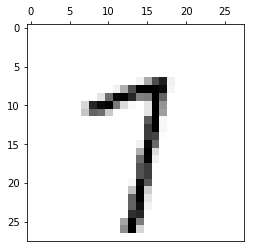

In [7]:
MNISTtools.show(xtrain[:,42])

In [8]:
print(ltrain[42])

7


I would've figured that to be a 1, but I guess it's a 7.

### 3

In [4]:
xtrain.max()

255

In [5]:
xtrain.min()

0

In [11]:
print(type(xtrain))
print(type(xtrain[1,1]))

<class 'numpy.ndarray'>
<class 'numpy.uint8'>


Range is 0-255, xtrain is an ndarray of uint8 variables.

### 4

In [7]:
def normalize_MNIST_images(x):
    normalized=x.astype(np.float32)
    normalized-=127.5
    normalized/=127.5
    return normalized

In [8]:
xtrain=normalize_MNIST_images(xtrain)

In [9]:
xtrain.max()

1.0

In [10]:
xtrain.min()

-1.0

In [11]:
print(type(xtrain))
print(type(xtrain[1,1]))

<class 'numpy.ndarray'>
<class 'numpy.float32'>


Now it's an ndarray of float32 type, as required.

### 5

In [8]:
def label2onehot(lbl):
    d = np.zeros((lbl.max() + 1, lbl.size))
    d[lbl,np.arange(lbl.size)] = 1
    return d

In [9]:
dtrain=label2onehot(ltrain)

In [19]:
print(dtrain[:,42])
print(ltrain[42])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
7


Indeed there is a 1 in the 7'th position only, rest are zeros.

### 6

In [10]:
def onehot2label(d):
    lbl = d.argmax(axis=0)
    return lbl

In [11]:
all(ltrain==onehot2label(dtrain))

True

## 4 Activation functions

### 7

In [12]:
def softmax(a):
    y=np.exp(a-a.max(axis=0))
    y/=y.sum(axis=0)
    return y

### 8

\begin{align}&\frac{dg(\textbf{a})_i}{da_i}=\frac{d}{da_i} \frac{exp(a_i - M)}{\sum_{j=0}^{10} exp(a_j -M)}\end{align}

Using the quotient rule for derivatives and the facts that:

\begin{align}&\frac{dexp(a_j - M)}{da_i} = 0 , i\neq j \\ &\frac{dexp(a_i - M)}{da_i} = exp(a_i - M)\end{align}

We get:

\begin{align}&\frac{d}{da_i} \frac{exp(a_i - M)}{\sum_{j=1}^{10} exp(a_j -M)} = \\
&\frac{exp(a_i - M)*\sum_{j=0}^{10} exp(a_j -M) - exp(a_i - M)* exp(a_i - M)}{(\sum_{j=1}^{10} exp(a_j -M))^2} = \\
&= \frac{exp(a_i - M)}{(\sum_{j=1}^{10} exp(a_j -M))^2} - \frac{(exp(a_i - M))^2}{(\sum_{j=1}^{10} exp(a_j -M))^2} = \\
&g(\textbf{a})_i-g(\textbf{a})_i^2 = g(\textbf{a})_i(1-g(\textbf{a})_i) .\square\end{align}

### 9

Similarly to section 8, for $i\neq j$:

\begin{align}&\frac{dg(\textbf{a})_i}{da_j}=\frac{d}{da_j} \frac{exp(a_i - M)}{\sum_{j=1}^{10} exp(a_j -M)} = \\
&=\frac{0-exp(a_i - M) exp(a_j - M)}{(\sum_{j=1}^{10} exp(a_j -M))^2} = \\
&=-\frac{exp(a_i - M)}{\sum_{j=1}^{10} exp(a_j -M)} \frac{exp(a_j - M)}{\sum_{j=1}^{10} exp(a_j -M)} = \\
&= -g(\textbf{a})_ig(\textbf{a})_j . \square\end{align}

### 10

Clearly, for $i\neq j$:$$\frac{dg(\textbf{a})_i}{da_j} = \frac{dg(\textbf{a})_j}{da_i}  = -g(\textbf{a})_ig(\textbf{a})_j$$from section 9. Thus, the Jacobian of softmax is symmetric since:$$(\frac{dg(\textbf{a})}{d\textbf{a}})_{i,j} = (\frac{dg(\textbf{a})}{d\textbf{a}})_{j,i}$$

So, multiplying directly and using the results of section 8 and 9 we get:
$$\boldsymbol{\delta} = [\frac{dg(\textbf{a})}{d\textbf{a}}]^T \times \textbf{e} = \begin{pmatrix} \frac{dg(\boldsymbol{a})_1}{da_1}*e_1 + ... +  \frac{dg(\boldsymbol{a})_{1}}{da_{10}}*e_{10}
\\ ...  
\\ \frac{dg(\boldsymbol{a})_{10}}{da_1}*e_1 + ... +  \frac{dg(\boldsymbol{a})_{10}}{da_{10}}*e_{10}
\end{pmatrix}$$ 
$$= \begin{pmatrix} \frac{dg(\boldsymbol{a})_1}{da_1}*e_1
\\ ...  
\\ \frac{dg(\boldsymbol{a})_{10}}{da_{10}}*e_{10}
\end{pmatrix} +\begin{pmatrix} \frac{dg(\boldsymbol{a})_1}{da_2}*e_2 + ... +  \frac{dg(\boldsymbol{a})_{1}}{da_{10}}*e_{10}
\\ ...  
\\ \frac{dg(\boldsymbol{a})_{10}}{da_1}*e_1 + ... +  \frac{dg(\boldsymbol{a})_{10}}{da_{9}}*e_{9}
\end{pmatrix}=$$ 
$$\\ g(\textbf{a}) \otimes \textbf{e} -<g(\textbf{a}),\textbf(e)>g(\textbf{a}) . \square$$ 
Where $e_i$ is the element in the $i$th position in the vector $\textbf{e}, i={1,...,10}$.

In [13]:
def softmaxp(a,e):
    sftmax=softmax(a)
    tmp=sftmax*e
    return tmp-tmp.sum(axis=0)*sftmax

### 11

In [24]:
eps = 1e-6 # finite difference step
a = np.random.randn(10, 200) # random inputs
e = np.random.randn(10, 200) # random directions
diff = softmaxp(a, e)
diff_approx = (softmax(a+eps*e)-softmax(a))/eps # Using the given definition
rel_error = np.abs(diff - diff_approx).mean() / np.abs(diff_approx).mean()
print(rel_error, 'should be smaller than 1e-6')

4.951952269743215e-07 should be smaller than 1e-6


Indeed.

### 12

In [14]:
def relu(a):
    return a*(a>0)
def relup(a, e):
    return e*(a>0)

## 5 Backpropagation

### 13

In [15]:
def init_shallow(Ni, Nh, No):
    b1 = np.random.randn(Nh, 1) / np.sqrt((Ni+1.)/2.)
    W1 = np.random.randn(Nh, Ni) / np.sqrt((Ni+1.)/2.)
    b2 = np.random.randn(No, 1) / np.sqrt((Nh+1.))
    W2 = np.random.randn(No, Nh) / np.sqrt((Nh+1.))
    return W1, b1, W2, b2

Ni = xtrain.shape[0]
Nh = 64
No = dtrain.shape[0]
netinit = init_shallow(Ni, Nh, No)

### 14

In [16]:
def forwardprop_shallow(x, net):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    a1 = W1.dot(x) + b1
    a2 = W2.dot(relu(a1)) + b2
    y=softmax(a2)
    return y

yinit = forwardprop_shallow(xtrain, netinit)

### 15

In [28]:
def eval_loss(y, d):
    return -np.sum(d*np.log(y))/d.size # according to the definition

print(eval_loss(yinit, dtrain), 'should be around .26')

0.2797001963013825 should be around .26


Indeed.

### 16

In [29]:
def eval_perfs(y, lbl):
    return np.sum(np.not_equal(np.argmax(y,axis=0),lbl))/lbl.size

print(eval_perfs(yinit, ltrain))

0.9279833333333334


First time has large error rate, we'll see it improves with more iterations.

### 17

Clearly $(\nabla_{\textbf{y}}E)_i = \nabla_{y_i}(-d_i logy_i) = -\frac{d_i}{y_i},\forall i\in [1,10].$

In [30]:
def update_shallow(x, d, net, gamma=.05):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    Ni = W1.shape[1]
    Nh = W1.shape[0]
    No = W2.shape[0]
    gamma = gamma / x.shape[1] # normalized by the training dataset size
    # Same as before here for forward pass
    a1 = W1.dot(x) + b1  
    a2 = W2.dot(relu(a1)) + b2
    y = softmax(a2)
    # Backprop
    delta2 = softmaxp(a2, -d/y)
    delta1 = relup(a1, W2.T.dot(delta2))
    W2 = W2 - gamma*delta2.dot(relu(a1).T)
    b2 = b2 - gamma*delta2.sum(axis=1).reshape(No,1)
    W1 = W1 - gamma*delta1.dot(x.T)
    b1 = b1 - gamma*delta1.sum(axis=1).reshape(Nh,1)
    
    return W1, b1, W2, b2


### 18

In [31]:
def backprop_shallow(x, d, net, T, gamma=.05):
    lbl = onehot2label(d)
    for t in range(T):
        net = update_shallow(x,d,net,gamma)
        y = forwardprop_shallow(x,net)
        l = eval_loss(y,d)
        err = eval_perfs(y, lbl)
        print("Iteration #"+str(t+1)+": Error = "+str(err)+", Loss = "+str(l)+'.')
    
    return net

In [32]:
nettrain = backprop_shallow(xtrain,dtrain,netinit,T=2)

Iteration #1: Error = 0.8689333333333333, Loss = 0.24246551027255084.
Iteration #2: Error = 0.8506833333333333, Loss = 0.23383431669776872.


In [33]:
nettrain = backprop_shallow(xtrain,dtrain,netinit,T=5)

Iteration #1: Error = 0.8689333333333333, Loss = 0.24246551027255084.
Iteration #2: Error = 0.8506833333333333, Loss = 0.23383431669776872.
Iteration #3: Error = 0.7326166666666667, Loss = 0.20922325651968723.
Iteration #4: Error = 0.6673333333333333, Loss = 0.19970592388194303.
Iteration #5: Error = 0.6174, Loss = 0.19173705965929722.


In [34]:
nettrain = backprop_shallow(xtrain,dtrain,netinit,T=20)

Iteration #1: Error = 0.8689333333333333, Loss = 0.24246551027255084.
Iteration #2: Error = 0.8506833333333333, Loss = 0.23383431669776872.
Iteration #3: Error = 0.7326166666666667, Loss = 0.20922325651968723.
Iteration #4: Error = 0.6673333333333333, Loss = 0.19970592388194303.
Iteration #5: Error = 0.6174, Loss = 0.19173705965929722.
Iteration #6: Error = 0.5543, Loss = 0.18452011963512463.
Iteration #7: Error = 0.5255666666666666, Loss = 0.1777871288440342.
Iteration #8: Error = 0.4755, Loss = 0.17148147461961294.
Iteration #9: Error = 0.46395, Loss = 0.16555088497154002.
Iteration #10: Error = 0.42183333333333334, Loss = 0.16000507081786172.
Iteration #11: Error = 0.4242166666666667, Loss = 0.15476590673692553.
Iteration #12: Error = 0.3836833333333333, Loss = 0.149896827340926.
Iteration #13: Error = 0.39525, Loss = 0.14530072242716038.
Iteration #14: Error = 0.3557666666666667, Loss = 0.14116414604658936.
Iteration #15: Error = 0.37755, Loss = 0.13729381703466625.
Iteration #16: 

In [35]:
nettrain = backprop_shallow(xtrain,dtrain,netinit,T=100)

Iteration #1: Error = 0.8689333333333333, Loss = 0.24246551027255084.
Iteration #2: Error = 0.8506833333333333, Loss = 0.23383431669776872.
Iteration #3: Error = 0.7326166666666667, Loss = 0.20922325651968723.
Iteration #4: Error = 0.6673333333333333, Loss = 0.19970592388194303.
Iteration #5: Error = 0.6174, Loss = 0.19173705965929722.
Iteration #6: Error = 0.5543, Loss = 0.18452011963512463.
Iteration #7: Error = 0.5255666666666666, Loss = 0.1777871288440342.
Iteration #8: Error = 0.4755, Loss = 0.17148147461961294.
Iteration #9: Error = 0.46395, Loss = 0.16555088497154002.
Iteration #10: Error = 0.42183333333333334, Loss = 0.16000507081786172.
Iteration #11: Error = 0.4242166666666667, Loss = 0.15476590673692553.
Iteration #12: Error = 0.3836833333333333, Loss = 0.149896827340926.
Iteration #13: Error = 0.39525, Loss = 0.14530072242716038.
Iteration #14: Error = 0.3557666666666667, Loss = 0.14116414604658936.
Iteration #15: Error = 0.37755, Loss = 0.13729381703466625.
Iteration #16: 

Indeed, converges to 13.26% error.

### 19

In [36]:
xtest, ltest=MNISTtools.load(dataset='testing')

In [37]:
print(xtest.shape)
print(ltest.shape)

(784, 10000)
(10000,)


Testing dataset has 10,000 items of dimension 784, like training dataset.

In [38]:
xtest = normalize_MNIST_images(xtest)
dtest = label2onehot(ltest)
pred = forwardprop_shallow(xtest,nettrain)
loss = eval_loss(pred,dtest)
err = eval_perfs(pred,ltest)
print("Test error: " + str(err)+", loss: " +str(loss))

Test error: 0.1258, loss: 0.04621737992507283


Test error is similar error rate to the training error rate.

### 20

In [39]:
def backprop_minibatch_shallow(x, d, net, T, B=100, gamma=.05):
    N = x.shape[1]
    NB = int((N+B-1)/B)
    lbl = onehot2label(d)
    for t in range(T):
        shuffled_indices = np.random.permutation(range(N))
        for l in range(NB):
            minibatch_indices = shuffled_indices[B*l:min(B*(l+1), N)]
            mnbtch_idx = minibatch_indices # to shorten next line for PDF
            net = update_shallow(x[:,mnbtch_idx],d[:,mnbtch_idx],net,gamma)
        y = forwardprop_shallow(x, net)
        loss = eval_loss(y,d)
        err = eval_perfs(y,lbl)
        print("Epoch #"+str(t+1)+": Error = "+str(err)+", loss = "+str(loss))
    return net

netminibatch = backprop_minibatch_shallow(xtrain, dtrain, netinit, 5, B=100)

Epoch #1: Error = 0.08661666666666666, loss = 0.0300963452764584
Epoch #2: Error = 0.066, loss = 0.023243066848732646
Epoch #3: Error = 0.06376666666666667, loss = 0.021502988627834563
Epoch #4: Error = 0.0532, loss = 0.017809165410952062
Epoch #5: Error = 0.04175, loss = 0.014805063819567477


Much faster convergence, much better error rate on training set.

### 21

In [40]:
pred=forwardprop_shallow(xtest,netminibatch)
loss=eval_loss(pred,dtest)
err=eval_perfs(pred,ltest)
print("Test error: " + str(err)+", loss: " +str(loss))

Test error: 0.0461, loss: 0.015902600521269197


Significantly better results for mini-batch in much less time than the usual backprop, indeed reached 95.4% test accuracy compared to 87.3% for regular descent. It could be that regular back prop led to overfitting due to the repeated testing of the same data points. 